In [1]:
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, \
    GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

raw_train_df = pd.read_csv('Data/fake_or_real_news_training.csv')
raw_test_df = pd.read_csv('Data/fake_or_real_news_test.csv')

raw_train_df.head()


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


# Data Exploration and Preparation

This analysis ultimately seeks to develop a model that can accurately discern "fake news" from real articles with the data sets provided including columns for the article ID, title, text, and the label (in the case of the training data). This section will first explore the data and clean it as necessary.

In [2]:
raw_train_df.shape

(3999, 6)

In [3]:
raw_test_df.shape

(2321, 3)

In [4]:
raw_test_df.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [5]:
prepared_train_df = raw_train_df.copy()
prepared_test_df = raw_test_df.copy()

From the below output, two main conclusions can be drawn:
1. X1 and X2 are populated in a very small minority of cases
2. There are rows that are improperly formatted as there should be only 2 unique values for the label


 As shown in the statistics below, X1 and X2 are populated in a very small number of cases- specifically 6 cases total

There are a few rows that are improperly formatted as there should be only 2 unique values for the label- we are calculating the percentage of rows to understand how much this can affect the data, since we do not have enough information to determine WHY they are missing.

In [6]:
prepared_train_df.nunique()

ID       3999
title    3968
text     3839
label      35
X1          4
X2          2
dtype: int64

In [7]:
#Calculate % of rows that have correct label values
((prepared_train_df['label'].values == 'FAKE').sum() 
 + (prepared_train_df['label'].values == 'REAL').sum())/len(prepared_train_df)


0.991747936984246

Based on the above calculation, 99% of rows have the proper format for label and therefore we have decided to drop the rows without the proper format in the code below.

In [8]:
#Exclude rows that are in an improper format
prepared_train_df = prepared_train_df[(prepared_train_df['label'] == 'FAKE') | (
    prepared_train_df['label'] == 'REAL')]

prepared_train_df.head()


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [9]:
prepared_train_df.shape

(3966, 6)

As the two labels appear to be very well balanced, no special sampling techniques are necessary.

Here we look at whether or not we have a balanced dataset to avoid any issues when running our model. You can see below that there is an almost even count of both real and fake news, and therefore no special sampling techniques, such as adding weights to either of the classes, need to be used.

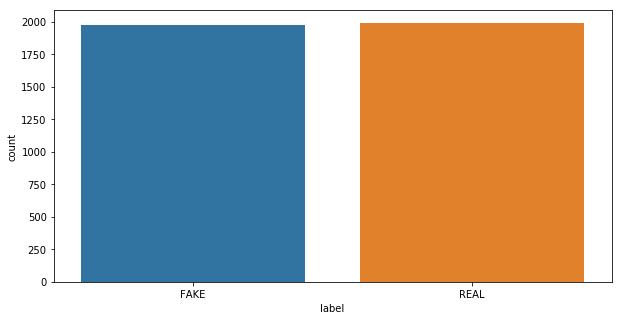

In [10]:
plt.figure(figsize=(10,5)) 
sns.countplot(prepared_train_df['label'])
plt.show()

# Baseline Modeling

The following helper functions were created for easier deployment and comparisons of different tokenization methodologies, models, and feature engineering that will be used later in this analysis. The use of pipelines allows for clean, efficient, reusable combinations of the different implementations that will be tested.

In [11]:
def score_model(df, model, vectorizer, target_var, independent_var,
                size=0.2, seed=12345, standalone=False, return_model=True):
    """
        Splits inputed dataframe into a train/test splits based on user specifications. 
        These splits will be used to fit a pipeline based on the entered algorithm and
        vectorizor. Returns the pipeline's score on the holdout, the holdout's labels,
        the prediction and by default the pipeline.
        --------
    """
    df_new = df.copy()

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=seed)

    # Toggle if pipeline or discrete model is passed
    if(standalone):
        pipeline = model.fit(X=X_train, y=y_train)
    else:
        pipeline = make_pipeline(vectorizer, model).fit(X=X_train, y=y_train)

    pred = pipeline.predict(X_test)

    # Toggle to include model in output
    if(return_model):
        return(pipeline.score(X_test, y_test), y_test, pred, pipeline)
    else:
        return(pipeline.score(X_test, y_test), y_test, pred)


def cv_evaluate(df, model, vectorizer, target_var, independent_var, seed=1234, 
                cv=5, standalone=False, metric='accuracy'):
    """
        Splits inputed dataframe into Kfold cross validation splits. 
        These splits will be used to fit a pipeline based on the entered 
        algorithm and vectorizor. Returns the pipeline's cross validation score.
        --------
    """
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]

    # Toggle if pipeline or discrete model is passed
    if(standalone):
        benchmark_model = make_pipeline(
            vectorizer, model).fit(X=X, y=y.values.ravel())
    else:
        benchmark_model = make_pipeline(model).fit(X=X, y=y.values.ravel())

    scores = cross_val_score(benchmark_model, X, y.values.ravel(),
                             scoring=metric, cv=kfolds)
    return scores[scores >= 0.0]


def tune_model(df, model, vectorizer, param, target_var, independent_var,
               seed=12345, cv=5, n_jobs=-1, gridSearch=False, verbose=True, metric='accuracy'):
    """
        Splits inputed dataframe into a train/test splits based on user specifications. 
        These splits will be used to fit a pipeline based on the entered algorithm and
        vectorizor. Returns an optimally tuned pipeline (both algorith and vectorizer) 
        based on inputed parameters.

        NOTE: Randomized Search can be implemented to reduce computation time.
        --------
    """
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    pipeline = Pipeline([vectorizer, model])

    # Toggle to run Grid Search or Randomized Search (to save on computation time)
    if(gridSearch):
        gsearch = GridSearchCV(estimator=pipeline, param_grid=param,
                               scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)
    else:
        gsearch = RandomizedSearchCV(estimator=pipeline, param_distributions=param,
                                     scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)

    gsearch.fit(X, y)
    tuned_model = gsearch.best_estimator_

    if(verbose):
        print('='*20)
        print("best params: " + str(gsearch.best_estimator_))
        print("best params: " + str(gsearch.best_params_))
        print('best score:', gsearch.best_score_)
        print('='*20)

    return tuned_model


def confusion_heat_map(test_set, prediction_set, class_names):
    """
        Returns a confusion heatmap comparing predicted labels against
        actual labels.
        --------
    """
    cm = confusion_matrix(test_set, prediction_set, class_names)
    fig, ax = plt.subplots()

    # create heatmap
    g = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g',
                    xticklabels=True, yticklabels=True)
    ax.xaxis.set_label_position("top")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.title('Confusion matrix', y=1.1)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def run_full_iteration(df, model, vectorizer, target_var, independent_var, size=0.2,
                       seed=12345, standalone=False, return_model=True, cv=5):
    """
        Sequentially runs score_model, cv_evaluate, and confusion_heat_map.
        --------
    """
    # Returns score on holdout set
    score, y_test, pred, model = score_model(
        df, model, vectorizer, target_var, independent_var, size,
        seed, standalone, return_model)
    print("Accuracy: %0.3f" % score)

    # Returns cross-validated score
    accuracy = cv_evaluate(df, model, vectorizer,
                           target_var, independent_var, seed, cv)
    print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
    print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))

    confusion_heat_map(y_test, pred, ['FAKE', 'REAL'])


def csv_conversion(df, y, id_field, old_target_name, filename, verbose=True):
    """
        Returns a pandas dataframe with the id_field and predicted values. Saves
        output as a CSV.
        --------
    """
    # Merge prediction with original data set to map with id
    raw_output = df.join(y)
    clean_output = raw_output.loc[:, [id_field, 0]]
    clean_output.columns = [id_field, old_target_name]
    clean_output.to_csv(filename, index=False)
    
    if(verbose):
        print(clean_output.head())
    return clean_output


def custom_stemmer(articles):
    """
        Returns stemmed text using the english implementations of the
        Snowball stemmer.
        --------
    """
    stemmer = SnowballStemmer("english")
    analyzer = TfidfVectorizer(stop_words='english').build_analyzer()
    return (stemmer.stem(w) for w in analyzer(articles))


class LemmaTokenizer(object):
    """
        Created Lemmatizer object that is pipeline compatible.
        --------
    """
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]


## Count Vectorizer

Here, we implement the count vectorizor function, or the Bag of Words approach, which creates a document term matrix, and then simply tokenizes a set of text and counts the number of times each token appears in the message. These counts are what populate the maxtrix. As can be seen from the below results, this simplistic methodology already yields decent results, with the Multinomial NB model performing the best out of the four.

In [12]:
# Set test set seed and target metric for the rest of the pipeline
seed = 12345
target_var = 'label'
independent_var = 'text'

models = []
models.append(('MNB', MultinomialNB()))
# models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto'))) #Fails to converge
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state = seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

vectorizer = CountVectorizer(stop_words='english')

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.881999 (0.009216)
RFC: 0.828034 (0.013075)
SVM: 0.858302 (0.015444)
PAC: 0.887295 (0.011185)


## Hashing Vectorizer

The hashing vectorizer is a more memory efficient tokenization/count implementation than the regular count vectorizer and the TDIF vectorizer. An improvement in score can be seen, however this is still a fairly simplistic implemntation.

Our implementation of term frequency utilizes a hash table data structure. A raw feature is mapped into an index (term) by applying a hash function. Then term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus, but it suffers from potential hash collisions, where different raw features may map to the same term after hashing. To reduce the chance of collision, we can increase the target feature dimension (i.e. the number of buckets of the hash table). 

In [13]:
vectorizer = HashingVectorizer(stop_words='english', non_negative=True)

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

MNB: 0.787197 (0.019901)
RFC: 0.791982 (0.005149)
SVM: 0.919569 (0.005595)
PAC: 0.918309 (0.006611)


## Tfid Vectorizer

On the other hand, TfidfVectorizer does everything the count vectorizer does, but also transforms the counts into TF/IDF values. This is crucially different because instead of relying on a raw count, it counts the frequency of words within the document and assigns a weight, and does the same across all documents. Becuase these weights are then divided, the overall weight decreases significantly, if it is an extremely common word. This is helpful in the case of stop words (the, and, is, etc.). As seen in the results below, using this methodology, a material improvement in prediction accuracy is made accross all models.

In [14]:
models = []
models.append(('MNB', MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

vectorizer = TfidfVectorizer(stop_words='english')

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.815941 (0.014094)
LR: 0.904436 (0.008532)
RFC: 0.816182 (0.016463)
SVM: 0.926122 (0.006668)
PAC: 0.927887 (0.007047)


## Full Analysis of Best Baseline Model

Based on the above results, it is clear that the winning combination is the Passive Aggressive Classifier (PAC) algorithm using Tfid Vectorizor. Put very simply, it is an algorithm that is well suited for large datasets because it doesn't store the data (Lavrenko 2014 https://bit.ly/2VUcBpk), making it a strong candidate for this use case. It gets an example, learns from the example, and throws it away. The PAC is "passive" in the sense that while in training, if it correctly classifies a particular instance, it does nothing and "aggressive" as it will update with incorrect classifications. 

It can be seen below that the high accuracy holds even with cross validation.

Accuracy: 0.912
Mean Accuracy after CV: 0.928 +/- 0.011
Best Accuracy after CV: 0.946


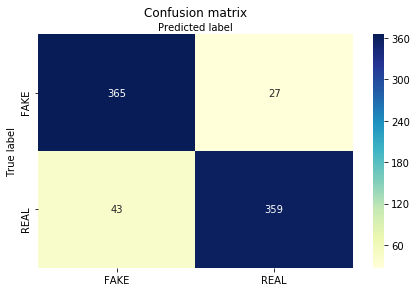

In [15]:
model = PassiveAggressiveClassifier(random_state=seed)
run_full_iteration(prepared_train_df, model, vectorizer, target_var, independent_var)


# Feature Engineering

## FE1: Combine Title and Text

The first engineered feature that will be attempted is combining the article title and text in a single string as the previous baselines only included the text. A marked improvement can be seen on the holdout accuracy as well as the average cross validated score. Therefore, this feature will be included in the combined engineering model.

In [16]:
fe1_train_df = prepared_train_df.copy()
fe1_test_df = prepared_test_df.copy()

fe1_train_df['combined'] = fe1_train_df['title'] + fe1_train_df['text']
fe1_test_df['combined'] = fe1_test_df['title'] + fe1_test_df['text']
fe1_train_df.head()

,ID,title,text,label,X1,X2,combined
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,Kerry to go to Paris in gesture of sympathyU.S...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,The Battle of New York: Why This Primary Matte...


Accuracy: 0.918
Mean Accuracy after CV: 0.929 +/- 0.011
Best Accuracy after CV: 0.945


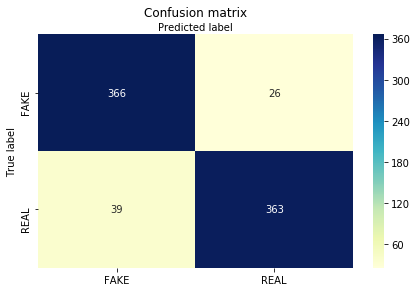

In [17]:
independent_var = 'combined'
run_full_iteration(fe1_train_df, model, vectorizer, target_var, independent_var)


## FE2: Stemming

The next feature will incorporate the English implementation of the Snowball stemmer. This essentially reduces words to their root without taking into account its context (e.g. "running" to "run", "quickly" to "quick", etc.) The process is easier and quicker to implement than Lemmatization (below), however it usually shows a decrease in accuracy over Lemmatization. After applied, this did slightly improve upon the holdout accuracy and the best cross validated accuracy, however it led to a greater decrease in the mean cross validated accuracy and therefore will not be included in the combined model.

Accuracy: 0.914
Mean Accuracy after CV: 0.925 +/- 0.011
Best Accuracy after CV: 0.943


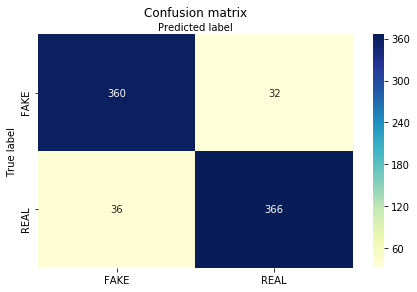

In [18]:
independent_var = 'text'
fe2_vectorizer = TfidfVectorizer(stop_words='english', analyzer=custom_stemmer)
run_full_iteration(prepared_train_df, model, fe2_vectorizer, target_var, independent_var)


## FE3: Lemmatization

Lemmatization operates very similarly to stemming with the critical difference of taking into account the context of the word/multiple meanings (e.g "better" to "good"). Its utilization results in a substanial improvement in the holdout accuracy as well as the mean cross validated accuracy (though at the expense of computation time). With this in mind, it will be kept for the combined feature engineering model.

Accuracy: 0.932
Mean Accuracy after CV: 0.937 +/- 0.010
Best Accuracy after CV: 0.943


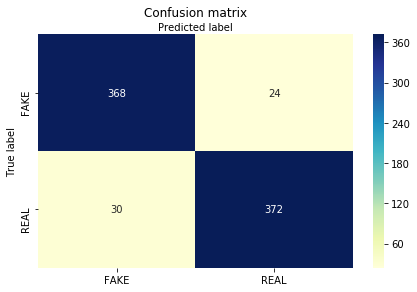

In [19]:
independent_var = 'text'
fe3_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
run_full_iteration(prepared_train_df, model, fe3_vectorizer, target_var, independent_var)


## Combining Feature Engineering

Combining both the addition of the article title and lemmatization, the resulting model performance is superior to both the baseline and addition of the title alone. However, there is a decrease in accuracy against lemmatization with regards to the holdout accuracy (despite improvements in cross validation). Ultimately both engineered features will be kept as combined they result in an overall improved score, but also, and maybe more importantly, a decrease in standard deviation among cross validated scores hinting at possibly better generalization.

Accuracy: 0.928
Mean Accuracy after CV: 0.938 +/- 0.009
Best Accuracy after CV: 0.946


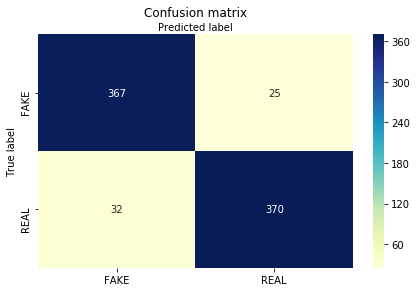

In [20]:
independent_var = 'combined'
fe_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
run_full_iteration(fe1_train_df, model, fe_vectorizer, target_var, independent_var)


# Hyperparameter Tuning

With the engineered features set, the next step in improving the model pipeline involves tuning its hyperparameters. In particular focus will be the 'max_df' of the TFID vectorizer (representing the threshold at which to ignore words that commonly appear), 'ngram_range' of the TFID vectorizer (the range of the number of words to be stored in a single unit), and 'C' of the PAC algorithm (a regularization term). 

The optimal combination results in a model that is superior to previous iterations with regards to the holdout accuracy and cross validation accuracies.

In [21]:
param = {
    'tfidf__max_df': (0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'PAC__C': [0.5, 1, 2]
}

vectorizer_object = ('tfidf', fe_vectorizer)
model_object = ('PAC', model)

tuned_model = tune_model(fe1_train_df, model_object, vectorizer_object,
                         param, target_var, independent_var, gridSearch=True)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 65.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 103.3min finished


best params: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...12345, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False))])
best params: {'PAC__C': 2, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
best score: 0.9435199193141705


Accuracy: 0.941
Mean Accuracy after CV: 0.944 +/- 0.006
Best Accuracy after CV: 0.950


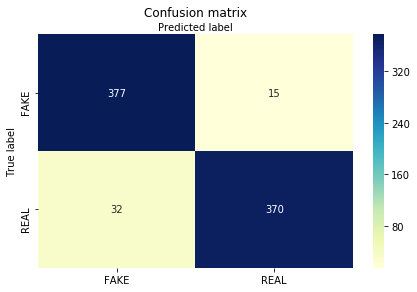

In [23]:
run_full_iteration(fe1_train_df, tuned_model, vectorizer,
                   target_var, independent_var, standalone=True)


# Predict on Test Set

This final section takes the final tuned model and runs a prediction on the clean/engineered test set. These predictions are then outputed into a .csv file.

In [24]:
final_pred = pd.DataFrame(tuned_model.predict(fe1_test_df['combined']))
final_clean_output = csv_conversion(fe1_test_df, final_pred,
                                    id_field='ID', old_target_name=target_var,
                                    filename="NLP_FAKE_NEWS_PREDICTIONS.csv")


      ID label
0  10498  FAKE
1   2439  REAL
2    864  REAL
3   4128  REAL
4    662  REAL


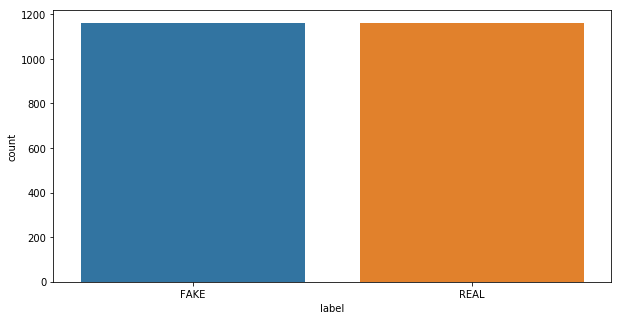

In [25]:
plt.figure(figsize=(10,5)) 
sns.countplot(final_clean_output['label'])
plt.show()